In [1]:
import time
import tensorflow as tf
from tensorflow.python.keras import Input, Sequential
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Lambda, Conv2D, Conv2DTranspose, LeakyReLU, GlobalMaxPooling2D, Reshape, Cropping2D, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
tf.compat.v1.enable_eager_execution()

# GAN

### 1.1 Data 
 Using the given dataset _ising_data.zip_, which are some Monte Carlo samples
of the standard ferromagnetic 2D Ising model on a square lattice of size 40x40 generated at different
temperatures. For each temperature there are $1001$ spin configurations. The factor indicates how
close it is to the critical temperature (e.g. 1 corresponds to 0.1βc, βc = 1/(TckB)). It contains various
numpy arrays so you can load the datasets using numpy.

In [2]:
class IsingData:
    """Data class."""
    def __init__(self, data_fraction=1./10):
        self.x_train = np.load('./ising_data/ising_11.npy')
        self.reshape_to_color_channel()

    def reshape_to_color_channel(self):
        self.x_train = self.x_train[:, :, :, np.newaxis]
        #self.x_test = self.x_test[:, :, :, np.newaxis]

### 1.2    GAN Implementation

Build a GAN with a custom training loop (as in sheet 10) that aims at generating Ising samples
below the critical temperature. Analyze the energy and magnetization of both the original dataset
and the generated Ising samples.

Note that in case you do not have a local environment where you can calculate on a GPU, you
can calculate online on collab on a GPU.

In [3]:
class GAN:
    def __init__(self, data: IsingData, num_classes=10):
        self.x_train = data.x_train
        
        self.train_dataset = None
        self.val_dataset = None

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape
        self.input = Input(shape=self.input_shape)
        self.output = None

        self.latent_dim = 128
        
        self.discriminator = None
        self.generator = None
        
        self.build_discriminator()
        self.build_generator()
        
        self.d_optimizer = None
        self.g_optimizer = None
        self.loss_fn = None

    def build_discriminator(self):
        """Build the discriminator."""
        self.discriminator = Sequential(
            [
                Input(shape=(40, 40, 1)),
                Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                GlobalMaxPooling2D(),
                Dense(1),
            ],
            name="discriminator",
        )
        
    def build_generator(self):
        """Build the generator."""
        latent_dim = self.latent_dim

        self.generator = Sequential(
            [
                Input(shape=(latent_dim,)),
                # We want to generate 128 coefficients to reshape into a 10x10x128 map
                Dense(10 * 10 * 128),
                LeakyReLU(alpha=0.2),
                Reshape((10, 10, 128)),
                Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                #Dropout(0.05),
                Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                #Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                #LeakyReLU(alpha=0.2),
                Conv2D(1, (10, 10), padding="same", activation="sigmoid"),
                #Cropping2D(cropping=((20, 20), (20, 20)))
            ],
            name="generator",
        )
    
    @tf.function
    def train_step(self, batch_size, real_images):
        """GAN training step."""
        latent_dim = self.latent_dim
        
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
        #random_latent_vectors = tf.random.uniform(shape=(batch_size, latent_dim), minval=-1, maxval=1) 
        
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        #Map tensor to either 0 or 1
        generated_images = tf.dtypes.cast(generated_images, tf.int8)
        #Map tensor to either -1 or +1 (spins)
        generated_images = 2*generated_images - tf.ones(shape=(batch_size, 40, 40, 1), dtype=tf.dtypes.int8)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(labels.shape)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return d_loss, g_loss, generated_images    
      
    def calculate_magnetization_dist(self, samples):
        """Returns magnetization distribution of given input samples"""
        magnetization_dist = np.zeros((100))
        for sample in samples:
            sample = sample.numpy()
            magnetization = abs(np.mean(sample))
            i = int(100*magnetization-1e-9)
            magnetization_dist[i] += 1
            
        return magnetization_dist
    
    def calculate_energy_dist(self, samples):
        """Returns energy distribution of given input samples"""
        energy_dist = np.zeros((100))
        for sample in samples:
            sample = sample.numpy()
            ener = 0
            for i in range(40):
                for j in range(40):
                    sp1 = sample[(i+1)%40,j]
                    sp2 = sample[i,(j+1)%40]
                    ener += - sample[i,j] * (sp1+sp2)
            #normalize energy
            ener = (ener)/(2*2*40) 
            ener = (ener + 1)/2
            i = int(100*ener-1e-9)
            energy_dist[i] += 1
        
        return energy_dist
            
    def plot_ising(self, real_sample, calc_sample):
        """Plots Monte-Carlo-samples in comparison to the generated samples"""
        fig = plt.figure()

        fig.set_figheight(5)
        fig.set_figwidth(15)
        gs = fig.add_gridspec(1, 2)
        
        ax = fig.add_subplot(gs[0, 0])
        ax.imshow(real_sample)
        ax.set_title('real_sample')
        
        ax = fig.add_subplot(gs[0, 1])
        ax.imshow(calc_sample)
        ax.set_title('calculated_sample')
        
        plt.tight_layout
        
        plt.show()
    
    def plot_dist(self, magnetization_real, magnetization_calc, energy_real, energy_calc):
        """Plots distribution functions of Monte-Carlo-samples in comparison to the generated samples"""
        
        mag_x = np.linspace(0,1,100)
        energ_x = np.linspace(-1,1,100)
        
        fig = plt.figure()

        fig.set_figheight(5)
        fig.set_figwidth(15)
        gs = fig.add_gridspec(2, 2, hspace=1)
        
        ax = fig.add_subplot(gs[0, 0])
        ax.plot(mag_x, magnetization_real)
        ax.set_title('magnetization_real')
        
        ax = fig.add_subplot(gs[0, 1])
        ax.plot(mag_x, magnetization_calc)
        ax.set_title('magnetization_calc')
        
        ax = fig.add_subplot(gs[1, 0])
        ax.plot(energ_x, energy_real)
        ax.set_title('energy_real')
        
        ax = fig.add_subplot(gs[1, 1])
        ax.plot(energ_x, energy_calc)
        ax.set_title('energy_calc')

        plt.show()
    
    def train_gan(self, batch_size=128, epochs=20):
        """training loop"""
        #Prepare dataset
        self.train_dataset = tf.data.Dataset.from_tensor_slices(self.x_train)
        self.train_dataset = self.train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        # Instantiate an optimizer.
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        # Instantiate a loss function.
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        #self.train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        #self.val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        
        start_time = time.time()
        
        real_images_f = None
        generated_images_f = None
        
        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time_epoch = time.time()

            # Iterate over the batches of the dataset.
            for step, real_images in enumerate(self.train_dataset):
                d_loss, g_loss, generated_images = self.train_step(batch_size, real_images)
                
                # Log for plotting
                real_images_f = real_images
                generated_images_f = generated_images
                
                # Log every 200 batches.
                if step % 200 == 0:
                    print(
                        "Discriminator loss (for one batch) at step %d: %.4f"
                        % (step, float(d_loss))
                    )
                    print(
                        "Generator loss (for one batch) at step %d: %.4f"
                        % (step, float(g_loss))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * batch_size))
            
            
            print("Time taken: %.2fs" % (time.time() - start_time_epoch))
            
            self.plot_ising(real_images_f[0], generated_images_f[0])
            
            magnetization_real = self.calculate_magnetization_dist(real_images_f)
            magnetization_calc = self.calculate_magnetization_dist(generated_images_f)
                
            energy_real = self.calculate_energy_dist(real_images_f)
            energy_calc = self.calculate_energy_dist(generated_images_f)
            print('')
            
            self.plot_dist(magnetization_real, magnetization_calc, energy_real, energy_calc)
        
        

        
        print("\nTotal time taken: %.2fs" % (time.time() - start_time))
        



Start of epoch 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Discriminator loss (for one batch) at step 0: 0.6904
Generator loss (for one batch) at step 0: 0.7163
Seen so far: 128 samples
Time taken: 44.87s


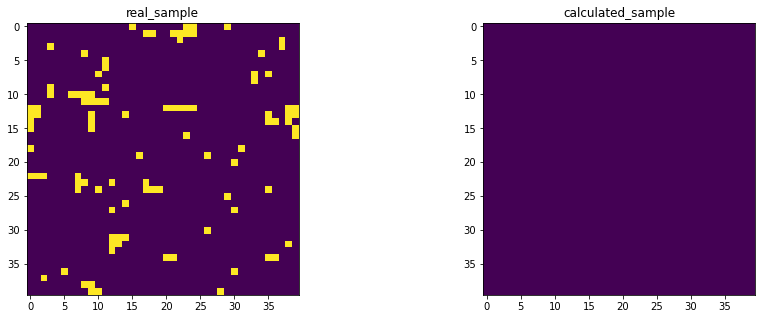

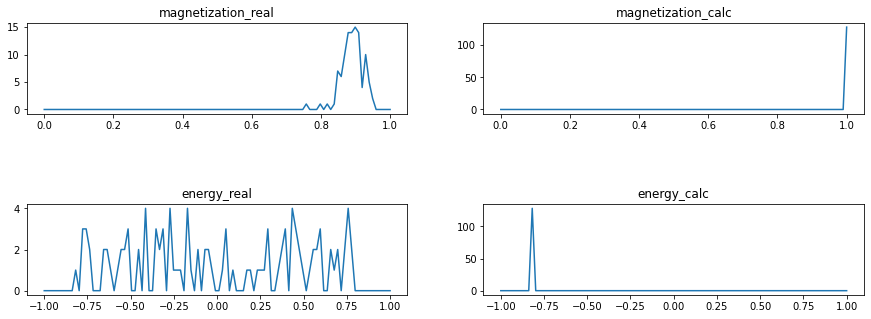


Start of epoch 1
Discriminator loss (for one batch) at step 0: 0.6626
Generator loss (for one batch) at step 0: 0.6920
Seen so far: 128 samples
Time taken: 43.98s


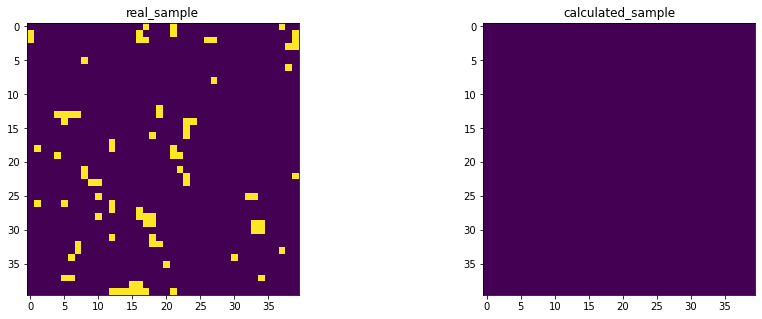

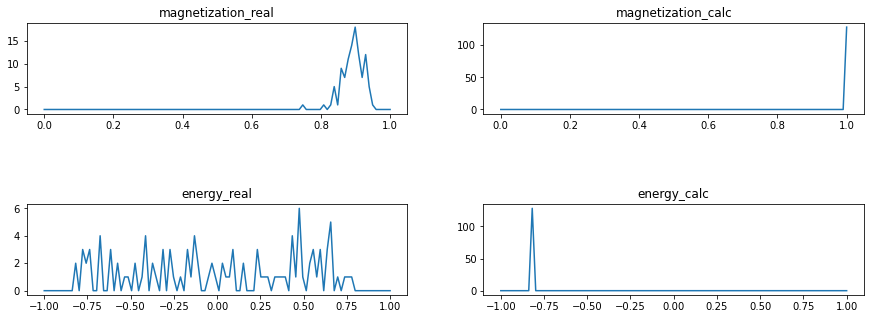


Start of epoch 2


KeyboardInterrupt: 

In [4]:
data = IsingData()

ising_gan = GAN(data)

ising_gan.train_gan()